In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import itertools 
import sys

In [6]:
"""
Трусенко Д.А. 06/15/2021
я не понял как добавлять библиотеки сфинкса в код питона 
и поэтому запись математики выглядит очень коряво
но думаю что тебе (Морозов А.Д.) плевать немножко
"""

'\nТрусенко Д.А. 06/15/2021\nя не понял как добавлять библиотеки сфинкса в код питона \nи поэтому запись математики выглядит очень коряво\nно думаю что тебе (Морозов А.Д.) плевать немножко\n'

In [ ]:
"""
Трусенко Д.А. 06/15/2021
Там где я мог понять что за тип я писал типы входных параметров,
Там где не мог - не писал
"""

In [ ]:
"""
Трусенко Д.А. 06/15/2021
Ильев еще и описания алгоритмов зажал (((
Я что разбираться должен в алгоритме чтобы Summary написать ?
"""

In [4]:
"""
Documentation and code are written using 
APPROXIMATION ALGORITHMS FOR A GRAPH CLUSTERING PROBLEM
by 
V.P. Il'ev, S.D. il'eva 
Dostoevsky Omsk State Uneversity, Omsk, Russia
A.V. Moroshin
Sobolev Institute of Mathematics SB RAS, Omsk, Russia
"""  


"\nDocumentation and code are written using \nAPPROXIMATION ALGORITHMS FOR A GRAPH CLUSTERING PROBLEM\nby \nV.P. Il'ev, S.D. il'eva \nDostoevsky Omsk State Uneversity, Omsk, Russia\nA.V. Moroshin\nSobolev Institute of Mathematics SB RAS, Omsk, Russia\n"

In [ ]:
class GraphWithComponents:
    def __init__(self, G, firstComponent, secondComponent):
        self.G = G
        self.firstComponent = firstComponent
        self.secondComponent = secondComponent
        pass

In [ ]:
def diff(G, H):
  """Returns p(G,H) - number of mismatched edges in graphs G, H 
  """
    return len(set(G.nodes) - set(H.nodes)) + len(set(H.nodes) - set(G.nodes))


In [ ]:
def A_plus(G, A, v):
  """ Returns A+ - number of vertices such that E(u,v) belongs to G
  "param G: graph
  :param A: set of vertices
  :param v: vertex
  """
    res = []
    for u in A:
        if G.has_edge(v, u) and v != u:
            res.append((v, u))
    return len(res)

In [ ]:
def A_minus(G, A, v):
  """ Returns A- - number of vertices such that E(u,v) doesn't belong to G
  "param G: graph
  :param A: set of vertices
  :param v: vertex
  """
    res = []
    for u in A:
        if not G.has_edge(v, u) and v != u:
            res.append((v, u))
    return len(res)

In [ ]:
def BBC(graph):
  """
    Chooses M_u such that p(G,M) = min p(G,M_u) where u belongs to V
    :param graph: graph G = (V,E)
    :return: cluster graph belonging to  M_<=2 (V)
  """
    M = None 
    p = sys.maxsize
    
    for node in graph.nodes:
        temp = nx.Graph()
        temp.add_nodes_from(graph)

        N_g = list(graph.neighbors(node))
        N_g.append(node)

        not_N_g = list(set(graph.nodes) - set(N_g))

        v1 = list(itertools.combinations(N_g, 2))
        v2 = list(itertools.combinations(not_N_g, 2))

        temp.add_edges_from(v1)
        temp.add_edges_from(v2)

        if(diff(temp, graph) < p):
            p = diff(temp, graph)
            
            firstComponent = nx.Graph()
            firstComponent.add_edges_from(v1)

            secondComponent = nx.Graph()
            secondComponent.add_edges_from(v2)
            
            M = GraphWithComponents(temp, firstComponent, secondComponent)

    return M

In [ ]:
def LS(graphWithComponents):
  """
  Слишком сложно разбираться чтобы написать Summary
  :param grapthWithComponents: claster graph M(X,Y) belonging to M_<=2(V)
  :type grapthWithComponents: GraphWithComponents
  :return: cluster graph NOT M = M(NOT X, NOT Y) belonging to M_<=2(V)
  """
    v_0 = None 
    v_0 = None
    sigma_v_0 = -sys.maxsize
    sigma_u_0 = -sys.maxsize
    
    for v in graphWithComponents.firstComponent.nodes:
        
        X_plus_v = A_plus(graphWithComponents.G, graphWithComponents.firstComponent.nodes, v)
        X_minus_v = A_minus(graphWithComponents.G, graphWithComponents.firstComponent.nodes, v)
        Y_plus_v = A_plus(graphWithComponents.G, graphWithComponents.secondComponent.nodes, v)
        Y_minus_v = A_minus(graphWithComponents.G, graphWithComponents.secondComponent.nodes, v)
        
        temp_sigma_v = X_minus_v - X_plus_v + Y_plus_v - Y_minus_v
        
        if temp_sigma_v > sigma_v_0:
            sigma_v_0 = temp_sigma_v
            v_0 = v
            
    for u in graphWithComponents.secondComponent.nodes:
        X_plus_u = A_plus(graphWithComponents.G, graphWithComponents.firstComponent.nodes, u)
        X_minus_u = A_minus(graphWithComponents.G, graphWithComponents.firstComponent.nodes, u)
        Y_plus_u = A_plus(graphWithComponents.G, graphWithComponents.secondComponent.nodes, u)
        Y_minus_u = A_minus(graphWithComponents.G, graphWithComponents.secondComponent.nodes, u)
        
        temp_sigma_u = Y_minus_u - Y_plus_u + X_plus_u - X_minus_u
        
        if(temp_sigma_u > sigma_u_0):
            sigma_u_0 = temp_sigma_u
            u_0 = u
    
    if sigma_v_0 <= 0 and sigma_u_0 <= 0:
        return graphWithComponents
    
    if sigma_v_0 >= sigma_u_0:
        newFirstComponent = graphWithComponents.firstComponent
        newFirstComponent.remove_node(v_0)
        
        newSecondComponent = graphWithComponents.secondComponent
        newSecondComponent.add_node(v_0)
        for node in newSecondComponent.node:
            if node != v_0:
                newSecondComponent.add_edge(v_0, node)
        
        newGraphWithComponents = GraphWithComponents(graphWithComponents.G, newFirstComponent, newSecondComponent)

        return LS(newGraphWithComponents)
        
    if sigma_v_0 < sigma_u_0:
        newFirstComponent = graphWithComponents.firstComponent
        newFirstComponent.add_node(u_0)
        for node in newFirstComponent.node:
            if node != u_0:
                newSecondComponent.add_edge(u_0, node)
        
        newSecondComponent = graphWithComponents.secondComponent
        newSecondComponent.remove_node(u_0)
        
        newGraphWithComponents = GraphWithComponents(graphWithComponents.G, newFirstComponent, newSecondComponent)
        
        return LS(newGraphWithComponents) 

In [ ]:
def CSW(graph):
  """
  Using LS procedure to redefine step 2 in BBC procedure 
  Chooses NOT M_u such that p(G,M) = min p(G, NOT M_u) where u belongs to V
  :param graph: graph G = (V,E)
  :return: cluster graph M belonging to M_<=2(V)
  """
  
    M = None
    p = sys.maxsize
    
    for node in graph.nodes:
        temp = nx.Graph()
        temp.add_nodes_from(graph)

        N_g = list(graph.neighbors(node))
        N_g.append(node)

        not_N_g = list(set(graph.nodes) - set(N_g))

        v1 = list(itertools.combinations(N_g, 2))
        v2 = list(itertools.combinations(not_N_g, 2))

        temp.add_edges_from(v1)
        temp.add_edges_from(v2)
        
        firstComponent = nx.Graph()
        firstComponent.add_edges_from(v1)

        secondComponent = nx.Graph()
        secondComponent.add_edges_from(v2)
        
        graphWithComponents = GraphWithComponents(temp, firstComponent, secondComponent)
        tempM = LS(graphWithComponents)
        
        if(diff(tempM.G, graph) < p):
            M = tempM
            
    return M

<class 'tuple'>


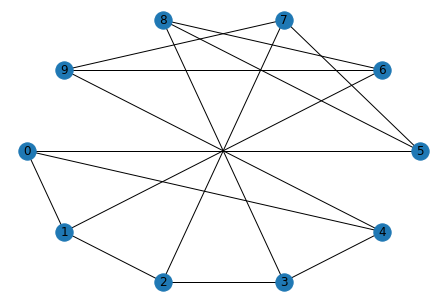

In [ ]:
G = nx.petersen_graph()
nx.draw_shell(G, with_labels=True)

print(type(list(G.edges)[1]))

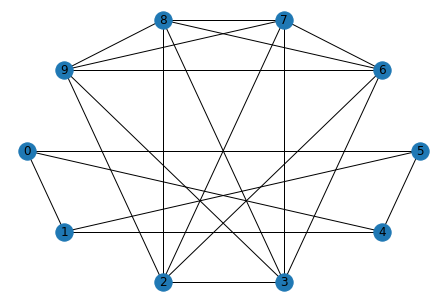

In [ ]:
M = BBC(G)
nx.draw_shell(M.G, with_labels=True)

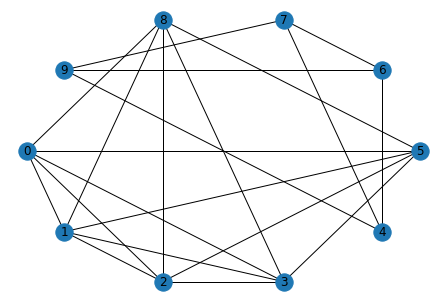

In [ ]:
M = CSW(G)
nx.draw_shell(M.G, with_labels=True)